## Setup

In [2]:
# Import statement
import xarray as xr
from typing import List
import cartopy.crs as ccrs
import numpy as np
import xskillscore as xs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

# Set default style to dark background because I like it better
plt.style.use("dark_background")

In [3]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    """Overwrite 'ne' values in the DataArray or Dataset."""
    da["ne"] = range(5)
    return da


def stack_and_chunk(data_arrays, dim_name, chunk_size):
    """Concatenate, stack, and chunk the given data arrays."""
    return (
        xr.concat(data_arrays, dim=dim_name)
        .stack(run=(dim_name, "ne"))
        .chunk({"run": chunk_size})
    )


def process_variable(
    wofs_list: List[xr.Dataset], var_name: str, overwrite: bool = False
) -> xr.DataArray:
    """Process a variable data with optional 'ne' overwrite."""
    data_arrays = [
        overwrite_ne(getattr(ds, var_name)) if overwrite else getattr(ds, var_name)
        for ds in wofs_list
    ]
    return stack_and_chunk(data_arrays, "init", "auto" if overwrite else -1)

In [4]:
# Load in 20-23Z initializations
wofs_all = [get_wofs_all(i) for i in [20,21,22,23]]

In [4]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

In [5]:
# Some useful functions
def get_mean_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the mean of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Mean variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).mean(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})

## 01 to 02 UTC rainfall

In [6]:
# Get the 01 to 02 UTC rainfall
rain12 = xr.concat(
    [
        w.rain.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")).sum(
            dim="time"
        )
        for w in wofs_all
    ],
    dim=init,
).chunk({"init":-1})

In [7]:
# Find the point closest to Central Park

# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Extract the rainfall value
rain12_nyc = rain12.isel(lat=lat_ind, lon=lon_ind)

## Get PW around Atlantic City

In [35]:
# Get time-average PW
pw230 = get_mean_field(wofs_all,"pw","2021-09-01 23:00:00", "2021-09-02 00:00:00", init)
pw01 = get_mean_field(wofs_all,"pw","2021-09-02 00:00:00", "2021-09-02 01:00:00", init)

In [36]:
# Set desired latitude and longitude (Atlantic City)
ac_lat, ac_lon = 39.3643, -74.4230

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - ac_lat) ** 2 + (lon - ac_lon) ** 2)
ac_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(ac_inds["NY"]), int(ac_inds["NX"])

# Extract PW values in a 48 km box centered on the point
pw01_ac = pw01.isel(
    lat=slice(lat_ind - 8, lat_ind + 8), lon=slice(lon_ind - 8, lon_ind + 8)
).mean(dim=["lat", "lon"])

### Make scatterplot and calculate Spearman rank correlation

In [37]:
# Calculate Spearman rank correlation between precipitable water and nyc rainfall
corr = xs.spearman_r(pw01_ac.chunk({"init":-1}), rain12_nyc.chunk({"init":-1}), dim=None).load()

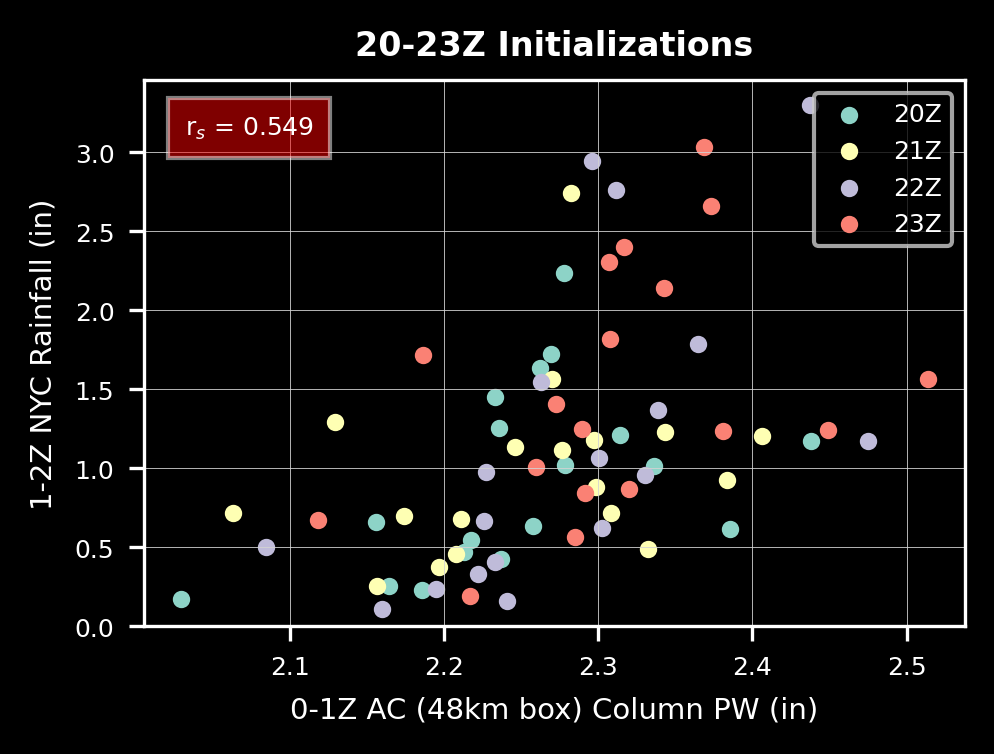

In [23]:
# Make figure
fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.4), dpi=300, layout="constrained")

# Create labels
labels = ["20Z", "21Z", "22Z", "23Z"]

# Plot scatterplot
for i, l in zip(pw01_ac.init, labels):
    ax.scatter(pw01_ac.sel(init=i), rain12_nyc.sel(init=i), s=10, label=l)
ax.tick_params(axis="x", which="both", labelsize=6, labelbottom=True)
ax.tick_params(axis="y", which="both", labelsize=6, labelleft=True)
ax.grid(color="lightgray", linewidth=0.2)
ax.set_ylim(0, None)
ax.set_xlabel("0-1Z AC (48km box) Column PW (in)", fontsize=7)
ax.set_ylabel("1-2Z NYC Rainfall (in)", fontsize=7)
ax.set_title("20-23Z Initializations", fontsize=8, fontweight="bold")

ax.text(
    0.05,
    0.9,
    "r$_s$ = " + str(float(corr.round(3))),  # type: ignore
    fontsize=6,
    bbox=dict(facecolor="red", alpha=0.5),
    transform=ax.transAxes,
)

ax.legend(loc="best",fontsize=6)

plt.show()

### Spatial correlation map

In [38]:
corr_01 = xs.spearman_r(pw01, rain12_nyc, dim=["ne", "init"]).load()
pval_01 = xs.spearman_r_p_value(pw01, rain12_nyc, dim=["ne", "init"]).load()

corr_230 = xs.spearman_r(pw230, rain12_nyc, dim=["ne", "init"]).load()
pval_230 = xs.spearman_r_p_value(pw230, rain12_nyc, dim=["ne", "init"]).load()

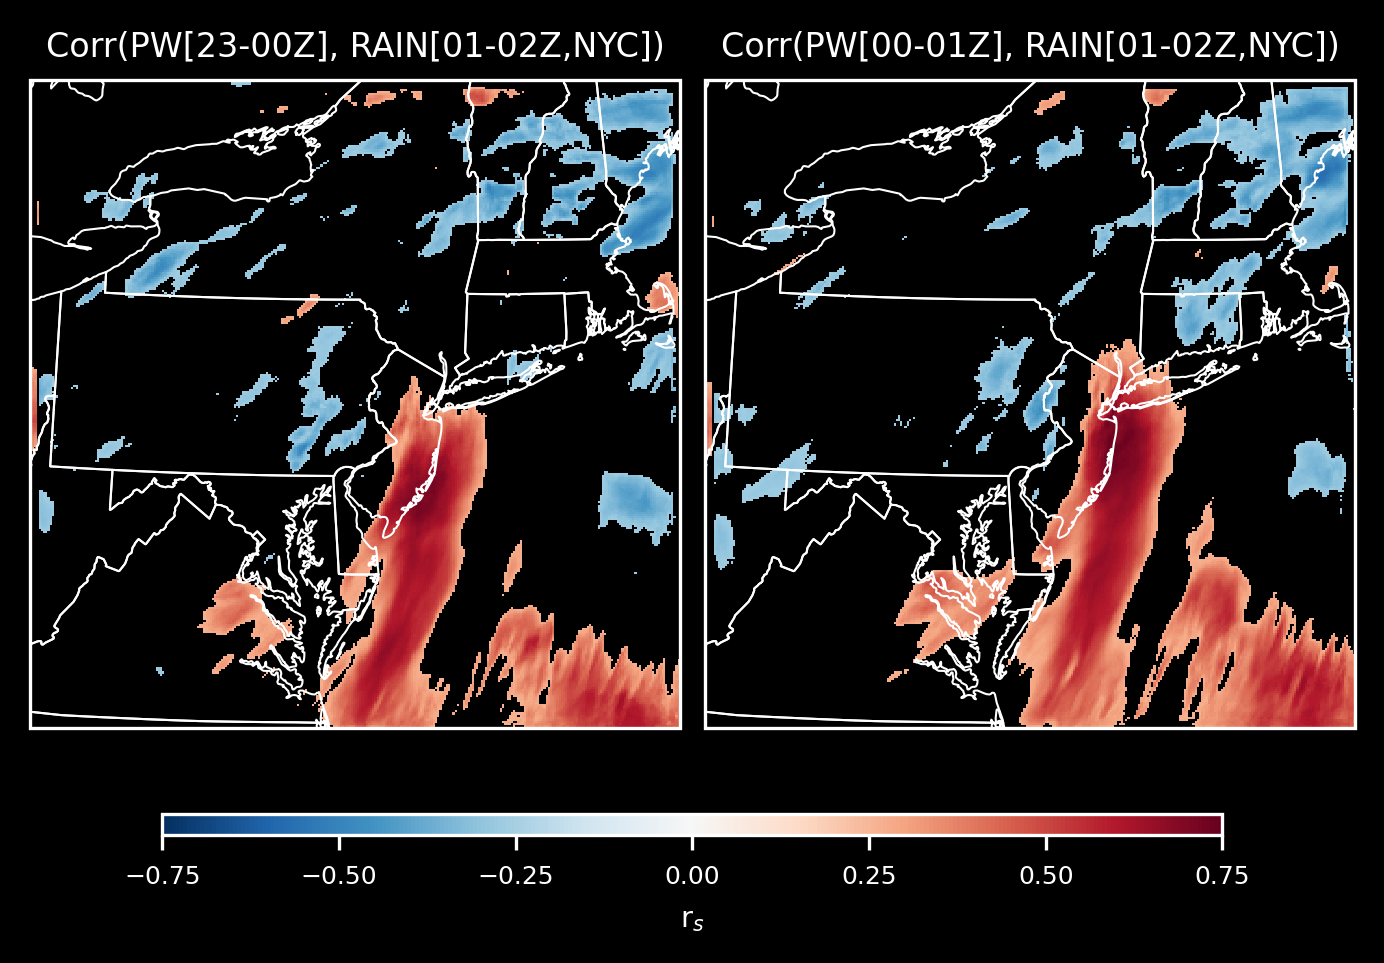

In [18]:
# Get data to plot
data = [corr_230, corr_01]
pdata = [pval_230, pval_01]
titles = ["Corr(PW[23-00Z], RAIN[01-02Z,NYC])", "Corr(PW[00-01Z], RAIN[01-02Z,NYC])"]

# Make figure
fig, axes = plt.subplots(
    1,
    2,
    figsize=(
        4.5,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i])<0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i],fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])

plt.show()

## V850

In [47]:
# Get time-averaged V850
v850_230 = get_mean_field(
    wofs_all, "V_850", "2021-09-01 23:00:00", "2021-09-02 00:00:00", init
)
v850_01 = get_mean_field(
    wofs_all, "V_850", "2021-09-02 00:00:00", "2021-09-02 01:00:00", init
)

In [48]:
corr_01 = xs.spearman_r(v850_01, rain12_nyc, dim=["ne", "init"]).load()
pval_01 = xs.spearman_r_p_value(v850_01, rain12_nyc, dim=["ne", "init"]).load()

corr_230 = xs.spearman_r(v850_230, rain12_nyc, dim=["ne", "init"]).load()
pval_230 = xs.spearman_r_p_value(v850_230, rain12_nyc, dim=["ne", "init"]).load()

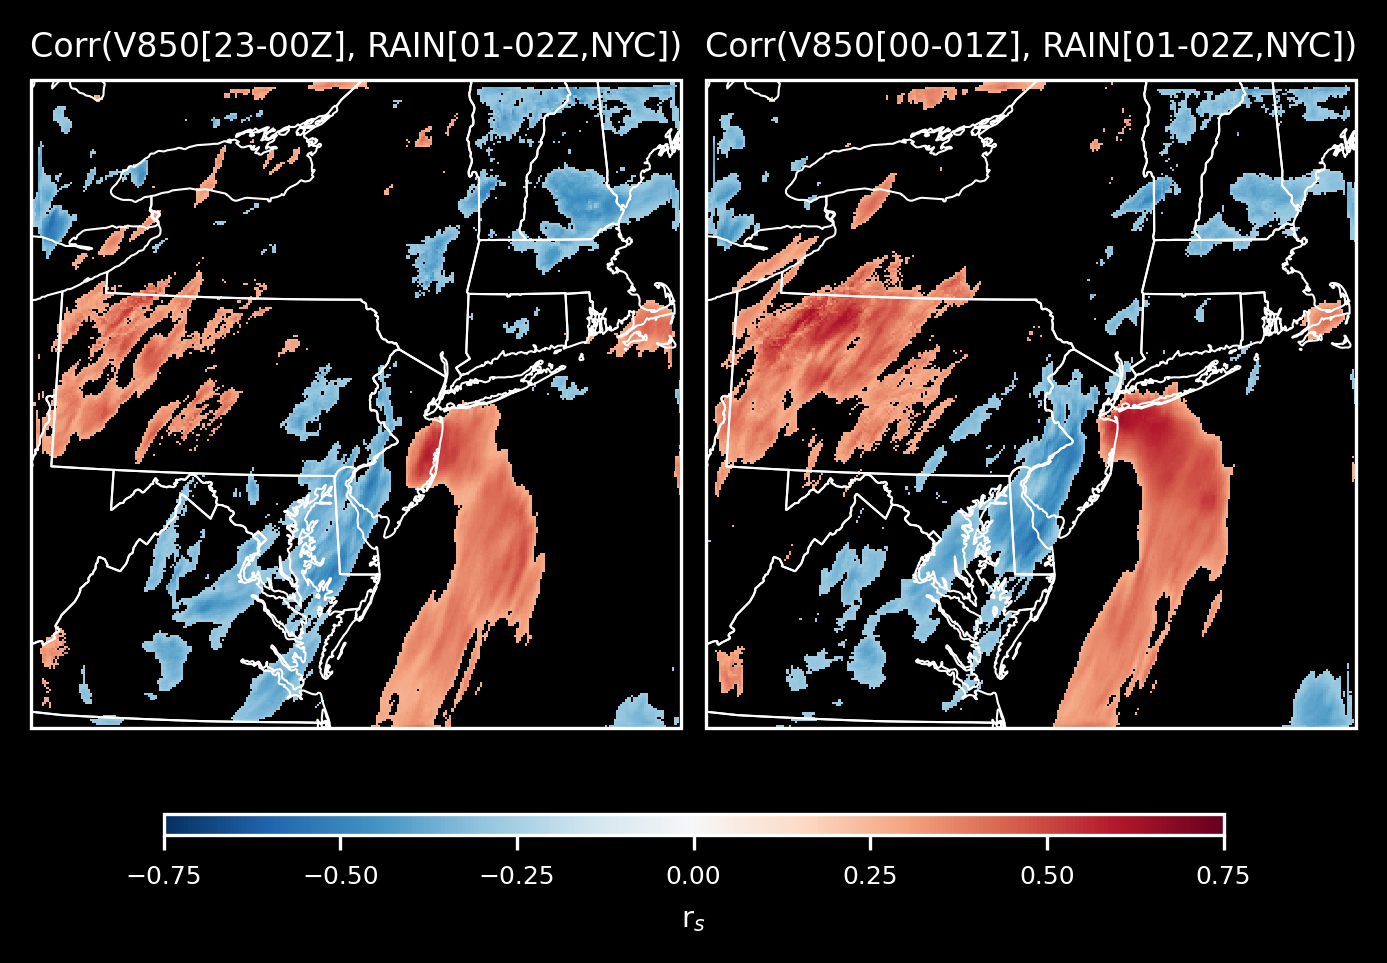

In [49]:
# Get data to plot
data = [corr_230, corr_01]
pdata = [pval_230, pval_01]
titles = [
    "Corr(V850[23-00Z], RAIN[01-02Z,NYC])",
    "Corr(V850[00-01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    2,
    figsize=(
        4.5,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75,0.76,0.25))  # type: ignore

plt.show()

## U850

In [8]:
# Get time-averaged u850
u850_230 = get_mean_field(
    wofs_all, "U_850", "2021-09-01 23:00:00", "2021-09-02 00:00:00", init
)
u850_01 = get_mean_field(
    wofs_all, "U_850", "2021-09-02 00:00:00", "2021-09-02 01:00:00", init
)

In [10]:
corr_01 = xs.spearman_r(u850_01, rain12_nyc, dim=["ne", "init"]).load()
pval_01 = xs.spearman_r_p_value(u850_01, rain12_nyc, dim=["ne", "init"]).load()

corr_230 = xs.spearman_r(u850_230, rain12_nyc, dim=["ne", "init"]).load()
pval_230 = xs.spearman_r_p_value(u850_230, rain12_nyc, dim=["ne", "init"]).load()

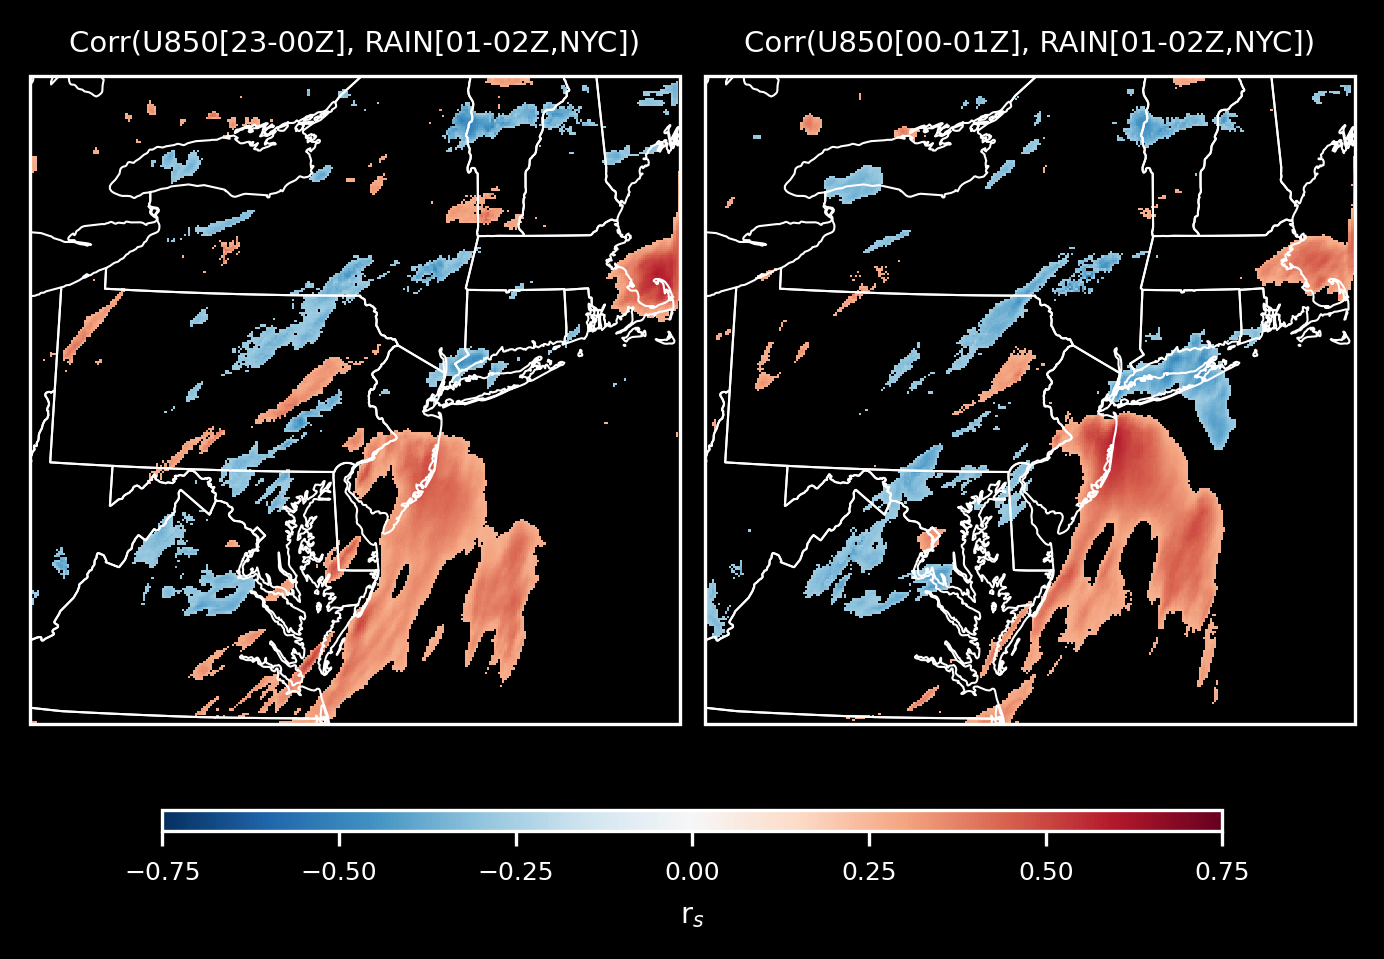

In [11]:
# Get data to plot
data = [corr_230, corr_01]
pdata = [pval_230, pval_01]
titles = [
    "Corr(U850[23-00Z], RAIN[01-02Z,NYC])",
    "Corr(U850[00-01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    2,
    figsize=(
        4.5,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75,0.76,0.25))  # type: ignore

plt.show()

## CAPE

In [51]:
# Get time-averaged CAPE
cape_230 = get_mean_field(
    wofs_all, "cape_ml", "2021-09-01 23:00:00", "2021-09-02 00:00:00", init
)
cape_01 = get_mean_field(
    wofs_all, "cape_ml", "2021-09-02 00:00:00", "2021-09-02 01:00:00", init
)

In [52]:
corr_01 = xs.spearman_r(cape_01, rain12_nyc, dim=["ne", "init"]).load()
pval_01 = xs.spearman_r_p_value(cape_01, rain12_nyc, dim=["ne", "init"]).load()

corr_230 = xs.spearman_r(cape_230, rain12_nyc, dim=["ne", "init"]).load()
pval_230 = xs.spearman_r_p_value(cape_230, rain12_nyc, dim=["ne", "init"]).load()

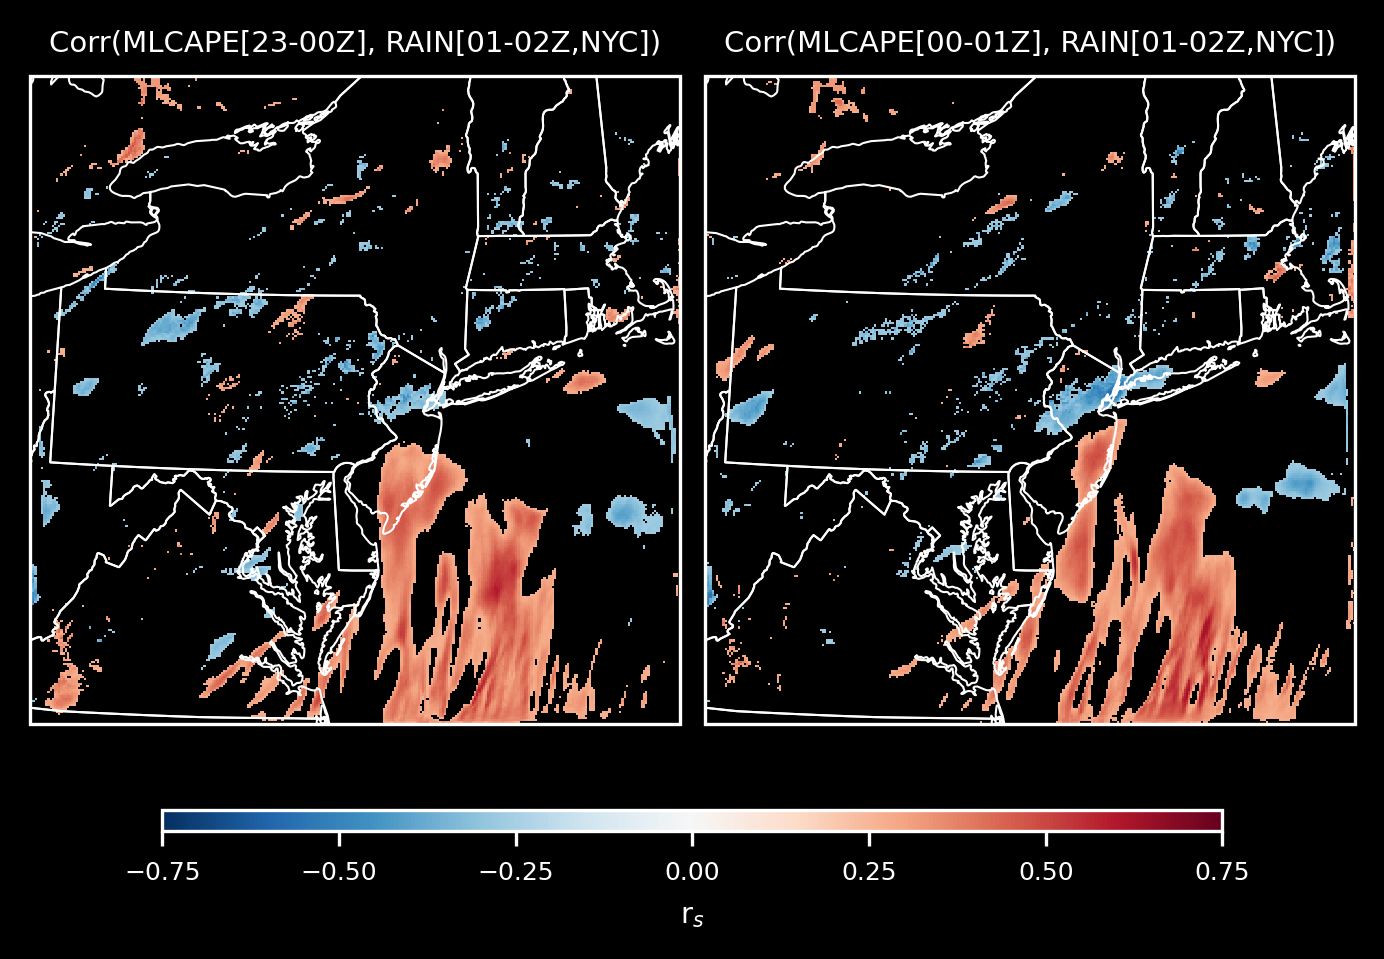

In [58]:
# Get data to plot
data = [corr_230, corr_01]
pdata = [pval_230, pval_01]
titles = [
    "Corr(MLCAPE[23-00Z], RAIN[01-02Z,NYC])",
    "Corr(MLCAPE[00-01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    2,
    figsize=(
        4.5,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75,0.76,0.25))  # type: ignore

plt.show()

## Z500

In [67]:
# Get time-averaged Z500
z500_230 = get_mean_field(
    wofs_all, "geo_hgt_500", "2021-09-01 23:00:00", "2021-09-02 00:00:00", init
)
z500_01 = get_mean_field(
    wofs_all, "geo_hgt_500", "2021-09-02 00:00:00", "2021-09-02 01:00:00", init
)

In [68]:
corr_01 = xs.spearman_r(z500_01, rain12_nyc, dim=["ne", "init"]).load()
pval_01 = xs.spearman_r_p_value(z500_01, rain12_nyc, dim=["ne", "init"]).load()

corr_230 = xs.spearman_r(z500_230, rain12_nyc, dim=["ne", "init"]).load()
pval_230 = xs.spearman_r_p_value(z500_230, rain12_nyc, dim=["ne", "init"]).load()

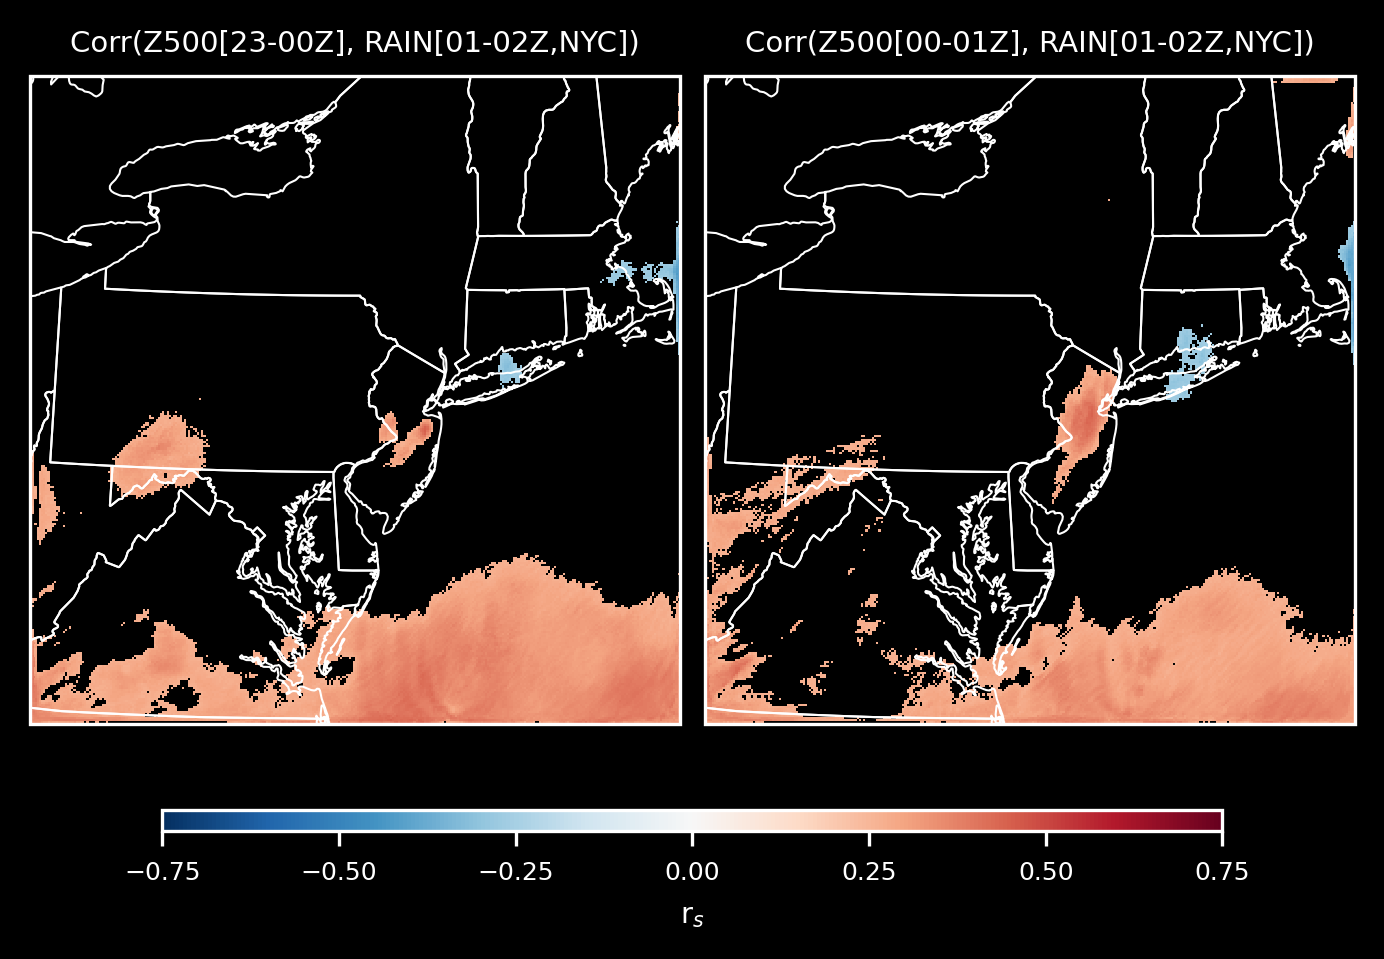

In [69]:
# Get data to plot
data = [corr_230, corr_01]
pdata = [pval_230, pval_01]
titles = [
    "Corr(Z500[23-00Z], RAIN[01-02Z,NYC])",
    "Corr(Z500[00-01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    2,
    figsize=(
        4.5,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75,0.76,0.25))  # type: ignore

plt.show()

## Preceding rainfall

In [61]:
# Get time-averaged rain
rain_231 = get_total_field(
    wofs_all, "rain", "2021-09-01 23:05:00", "2021-09-02 01:00:00", init
)

In [62]:
corr_231 = xs.spearman_r(rain_231, rain12_nyc, dim=["ne", "init"]).load()
pval_231 = xs.spearman_r_p_value(rain_231, rain12_nyc, dim=["ne", "init"]).load()

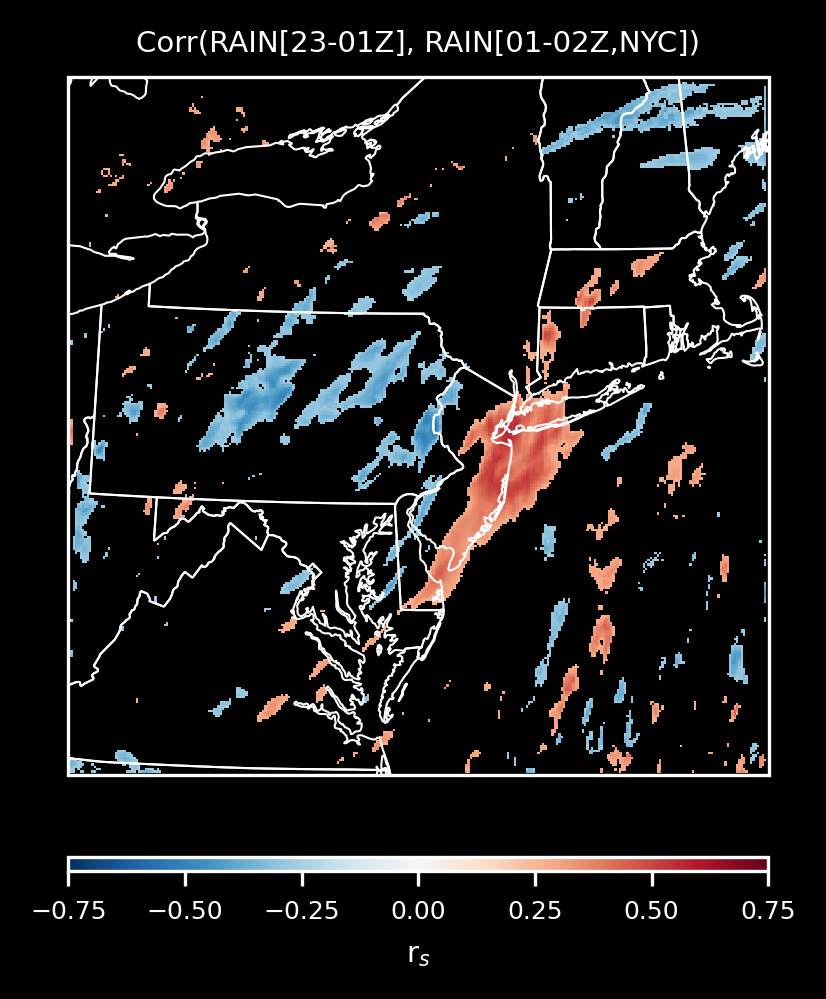

In [65]:
# Get data to plot
data = corr_231
pdata = pval_231
titles = "Corr(RAIN[23-01Z], RAIN[01-02Z,NYC])"

# Make figure
fig, ax = plt.subplots(
    1,
    1,
    figsize=(
        3,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
pc = ax.pcolormesh(
    lon,
    lat,
    data.where(np.fabs(pdata) < 0.025),
    cmap="RdBu_r",
    zorder=1,
    transform=ccrs.PlateCarree(),
    vmin=-0.75,
    vmax=0.75,
)

ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

ax.set_title(titles, fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=ax,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75, 0.76, 0.25))  # type: ignore

plt.show()

In [66]:

title = "NNJ Grid Box"

# Make figure
fig, ax = plt.subplots(
    1,
    1,
    figsize=(
        3,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

ax.set_title(titles, fontsize=7)

plt.show()

<xarray.Dataset> Size: 97GB
Dimensions:               (time: 73, ne: 18, lat: 300, lon: 300, NY: 300,
                           NX: 300, dim_0: 20, dim_1: 20, nz: 50, nx: 20, ny: 20)
Coordinates:
  * time                  (time) object 584B 2021-09-01 20:00:00 ... 2021-09-...
Dimensions without coordinates: ne, lat, lon, NY, NX, dim_0, dim_1, nz, nx, ny
Data variables: (12/114)
    10-500m_bulkshear     (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    QVAPOR_500            (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    QVAPOR_700            (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    QVAPOR_850            (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    U_500                 (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    U_700                 (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    ...                    ...
    wz_0to2_instant       (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    xlat                  (time, NY, NX) float32 26MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    xlat_snd              (time, dim_0, dim_1) float32 117kB dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    xlon                  (time, NY, NX) float32 26MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    xlon_snd              (time, dim_0, dim_1) float32 117kB dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    z_agl                 (time, ne, nz, nx, ny) float64 210MB dask.array<chunksize=(1, 18, 50, 20, 20), meta=np.ndarray>
Attributes: (12/98)
    TITLE:                            OUTPUT FROM WRF V3.9pre#2 MODEL
    START_DATE:                      2021-09-01_20:00:00
    WEST-EAST_GRID_DIMENSION:        301
    SOUTH-NORTH_GRID_DIMENSION:      301
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3000.0
    ...                              ...
    lon_pin:                         -80.55682
    lat_pin:                         36.372017
    init_time:                       20210901_200000
    valid_time:                      20210901_200000
    history:                         Mon Nov  6 22:10:28 2023: ncks --ovr -4 ...
    NCO:                             netCDF Operators version 5.0.4 (Homepage...